## Objectives

The project objective is to predict the probability of someone getting cancer based on a given data set containing some medical history information for patients at risk for cancer. Each patient in the data set has been diagnosed their actual cancer status. I built classifiers predicting whether a patient has cancer based on other features of that patient. 



## Data set 

The dependent variable is represented as a boolean variable, where 1 means the patient has cancer and 0 means they do not. There are 3 features:
    
    • age: Patient age is stored as a floating-point value, to give finer-grained detail than simply number of years.

    • famhistory: A boolean variable indicating whether or not a patient has a family history of cancer (as usual, 1 = true, indicating that the family does have a cancer history).

    • marker: A measured chemical marker that clinicians believe may have some correlation with the presence of cancer.


In [3]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns


### 1.1: Compute true/false positives/negatives.


In [4]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = ((ytrue_N == 1) & (yhat_N  == 1)).sum()
    TN = ((ytrue_N == 0) & (yhat_N  == 0)).sum()
    FP = ((ytrue_N == 0) & (yhat_N  == 1)).sum()
    FN = ((ytrue_N == 1) & (yhat_N  == 0)).sum()
    return TP, TN, FP, FN

In [5]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0, 0, 10, 0)

In [6]:
calc_TP_TN_FP_FN(all1, all0)

(0, 0, 0, 10)

In [7]:
calc_TP_TN_FP_FN(all1, all1)

(10, 0, 0, 0)

In [8]:
calc_TP_TN_FP_FN(all0, all0)

(0, 10, 0, 0)

### Supplied functions for later use



In [9]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [10]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df


In [11]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: hist of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])
#    plt.show()

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [12]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [13]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 1.2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training, validation, and testing sets (i.e., don't simply hand-count and print the values).

In [152]:
print("Fraction with cancer in TRAIN: {:.3f}".format(((y_tr_M == 1)).sum() / float(y_tr_M.size))) #TODO: modify what is printed here.
print("Fraction with cancer in VALID: {:.3f}".format(((y_va_N == 1)).sum() / float(y_va_N.size)) )
print("Fraction with cancer in TEST : {:.3f}".format(((y_te_N == 1)).sum() / float(y_te_N.size)) )

Fraction with cancer in TRAIN: 0.141
Fraction with cancer in VALID: 0.139
Fraction with cancer in TEST : 0.139


### 1.3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.



In [14]:
#print("Always-0: accuracy on VALID: %.3f" % 0.0) # TODO edit values!
#print("Always-0: accuracy on TEST : %.3f" % 0.0)
print("Always-0: accuracy on VALID: {:.3f}".format(((y_va_N== 0)).sum() / float(y_va_N.size))) 
print("Always-0: accuracy on TEST : {:.3f}".format(((y_te_N == 0)).sum() / float(y_te_N.size)) )
y_prob_valid = ((y_va_N== 0)).sum() / float(y_va_N.size)
print(y_prob_valid)

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861
0.8611111111111112


#### (b) Print a confusion matrix for the always-0 classifier.



In [16]:
# TODO call print(calc_confusion_matrix_for_threshold(...))
calc_confusion_matrix_for_threshold(y_va_N, np.zeros_like(y_va_N), 1.1)

Predicted,0,1
True,,
0,155,0
1,25,0


#### (c) Reflect on the accuracy of the always-0 classifier.

Plus: the always-0 classifier gives very high accuracry rate. For example, it gives both 86.1% accuracy on both valid and test sets. Also, it is very simple, leading to less computing time. 

Minus: first, the false negative rate is also very high as well (13.8%). Also, high accuracy does not make sense in this case as we want to find the positive case, aka the cases which the patient gets cancer. If we always predict that the patient does not get cancer, we are not able to cure cancer at all. It gives the same penalty level of both FP and FN, while in reality, the cost of FN is very high (predicting the patient does not have cancer while he/she has cancer) and the cost of FP is lower (predicting the patient has cancer while he/she does not have). 

#### (d) Analyze the various costs of using the always-0 classifier.


The always-0 classifier can make false negative mistake - it cannot make false positive one. That is, the classifier predicts the value of 0 (not cancer), while the true value is 1 (cancer). The cost of the mistake is loss of time and money. It can also cause deaths as we cannot predict cancer at all. Therefore, in reality, we prefer lower false negative rate, even with the trade off of false positive rate. We don't want to miss patients having cancer. Given the possibilities of this classifier, I don't recommend the always-0 classifier. This classifier is useless in real life. 

### 1.4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [29]:
tr_loss_list = list()
va_loss_list = list()
C_grid = np.logspace(-9, 6, 31)

log_loss_tr = []
log_loss_va = []
for C in C_grid:
    lrm = sklearn.linear_model.LogisticRegression(C = C, solver = 'liblinear').fit(x_tr_M2, y_tr_M)
    prob_pred_tr = lrm.predict_proba(x_tr_M2)
    prob_pred_va = lrm.predict_proba(x_va_N2)
    loss_tr = sklearn.metrics.log_loss(y_tr_M, prob_pred_tr)
    loss_va = sklearn.metrics.log_loss(y_va_N, prob_pred_va)
    log_loss_tr.append(loss_tr)
    log_loss_va.append(loss_va)
 

min_loss_va = min(log_loss_va)
min_loss_va_ind = log_loss_va.index(min_loss_va)
best_C_2 = C_grid[min_loss_va_ind]

best_model_2 = sklearn.linear_model.LogisticRegression(C = best_C_2, solver = 'liblinear').fit(x_va_N2, y_va_N)
y_prob_va_2 = [item[1] for item in best_model_2.predict_proba(x_va_N2)]




#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

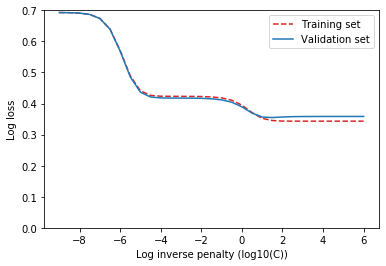

Best C-value for LR with 2-feature data: 0.355
Validation set log-loss at best C-value: 31.6228


In [18]:
fig, ax = plt.subplots()
ax.plot(np.log10(C_grid), log_loss_tr, label='Training set', color="tab:red", ls='--')
ax.plot(np.log10(C_grid), log_loss_va, label='Validation set', color="tab:blue")
plt.xlabel('Log inverse penalty (log10(C))')
plt.ylabel('Log loss')
plt.ylim([0.0, 0.7]);

ax.legend()
plt.show()

          
# Build and evaluate model for each value C
print("Best C-value for LR with 2-feature data: %.3f" % min_loss_va) # TODO
print("Validation set log-loss at best C-value: %.4f" % best_C_2)

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

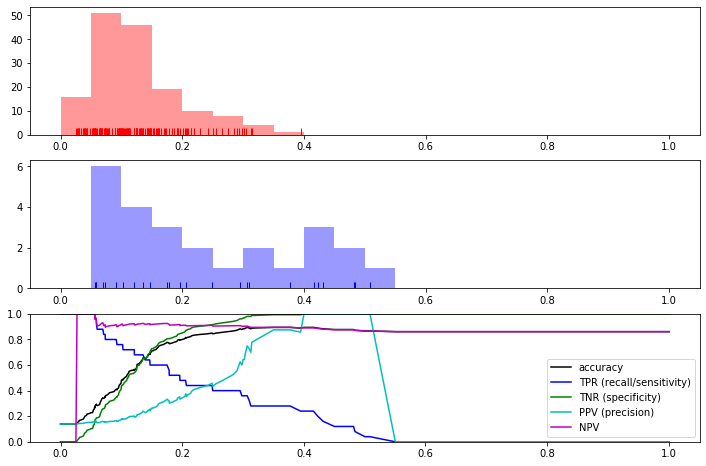

In [19]:
make_plot_perf_vs_threshold(y_va_N, np.array(y_prob_va_2))
plt.show()

#### (c) Model fitting with 3-feature data



In [21]:
tr_loss_list = list()
va_loss_list = list()
C_grid = np.logspace(-9, 6, 31)

log_loss_tr = []
log_loss_va = []
for C in C_grid:
    lrm = sklearn.linear_model.LogisticRegression(C = C, solver = 'liblinear').fit(x_tr_M3, y_tr_M)
    prob_pred_tr = lrm.predict_proba(x_tr_M3)
    prob_pred_va = lrm.predict_proba(x_va_N3)
    loss_tr = sklearn.metrics.log_loss(y_tr_M, prob_pred_tr)
    loss_va = sklearn.metrics.log_loss(y_va_N, prob_pred_va)
    log_loss_tr.append(loss_tr)
    log_loss_va.append(loss_va)
 

min_loss_va = min(log_loss_va)
min_loss_va_ind = log_loss_va.index(min_loss_va)
best_C_3 = C_grid[min_loss_va_ind]
          
best_model_3 = sklearn.linear_model.LogisticRegression(C = best_C_3, solver = 'liblinear').fit(x_va_N3, y_va_N)
y_prob_va_3 = [item[1] for item in best_model_3.predict_proba(x_va_N3)]



#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

Again, the best values for `C` and the loss should be printed.

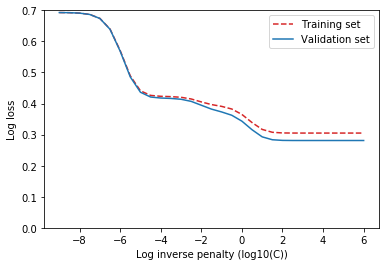

Best C-value for LR with 2-feature data: 0.281
Validation set log-loss at best C-value: 1000000.0000


In [22]:
fig, ax = plt.subplots()
ax.plot(np.log10(C_grid), log_loss_tr, label='Training set', color="tab:red", ls='--')
ax.plot(np.log10(C_grid), log_loss_va, label='Validation set', color="tab:blue")
plt.xlabel('Log inverse penalty (log10(C))')
plt.ylabel('Log loss')
plt.ylim([0.0, 0.7]);

ax.legend()
plt.show()

# Build and evaluate model for each value C
print("Best C-value for LR with 2-feature data: %.3f" % min_loss_va) # TODO
print("Validation set log-loss at best C-value: %.4f" % best_C_3)

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

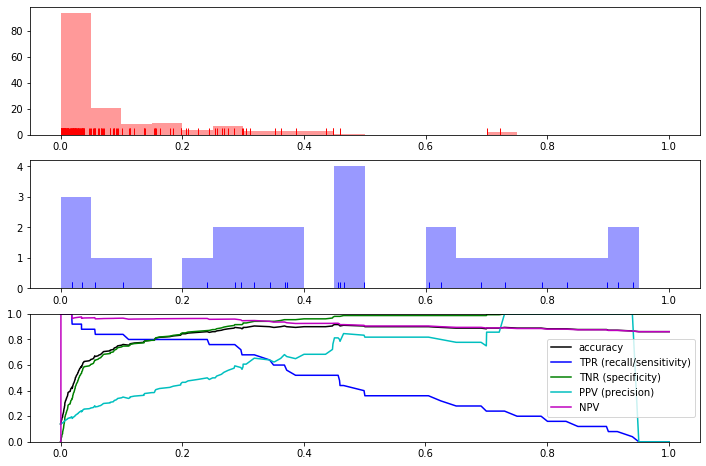

In [23]:
make_plot_perf_vs_threshold(y_va_N, np.array(y_prob_va_3))
plt.show()

### 1.5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.



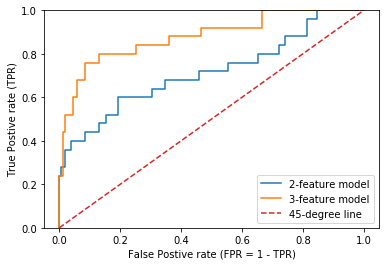

In [24]:
fpr2, tpr2, thr2 = sklearn.metrics.roc_curve(y_va_N, y_prob_va_2)
fpr3, tpr3, thr3 = sklearn.metrics.roc_curve(y_va_N, y_prob_va_3)

fig, ax = plt.subplots()
ax.plot(fpr2, tpr2, label='2-feature model')
ax.plot(fpr3, tpr3, label='3-feature model')
ax.plot(fpr2, fpr2, label='45-degree line', ls = '--', color = 'tab:red')
plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
ax.legend()
plt.show()

#### (b) Plot ROC curves on the test set.



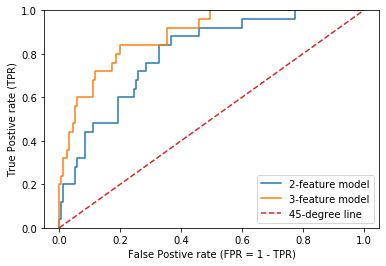

In [25]:
y_prob_te_2 = [item[1] for item in best_model_2.predict_proba(x_te_N2)]
y_prob_te_3 = [item[1] for item in best_model_3.predict_proba(x_te_N3)]

fpr2, tpr2, thr2 = sklearn.metrics.roc_curve(y_te_N, y_prob_te_2)
fpr3, tpr3, thr3 = sklearn.metrics.roc_curve(y_te_N, y_prob_te_3)

fig, ax = plt.subplots()
ax.plot(fpr2, tpr2, label='2-feature model')
ax.plot(fpr3, tpr3, label='3-feature model')
ax.plot(fpr2, fpr2, label='45-degree line', ls = '--', color = 'tab:red')
plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
ax.legend()
plt.show()

#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

On both validation and test sets, the 3-feature model has higher true positive rate than the 2-feature model, keeping the false positive rate at the same level. This is because more variables help predict and explain the results better. If we have fewer variables, most of the explanatory power still lies in the residual term, which cannot reflect on the true positive rate. We can also say that 2-feature model is underfitting compared with the 3-feature model.

### 1.6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [26]:
best_thr = 0.5


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_te_N, np.array(y_prob_te_3), best_thr))
print("")
# TODO: print(print_perf_metrics_for_threshold(...))
print(print_perf_metrics_for_threshold(y_te_N, np.array(y_prob_te_3), best_thr))


ON THE VALIDATION SET:
Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          150   5
1           14  11

0.894 ACC
0.440 TPR
0.968 TNR
0.687 PPV
0.915 NPV
None


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [27]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, y_prob_va_3)

# TODO Find threshold that makes TPR as large as possible, while satisfying PPV >= 0.98
max_tpr = -1
best_thr = 0
for item in range(thresh_grid.size):
    tpr = perf_grid['tpr'][item]
    ppv = perf_grid['ppv'][item]
    if (tpr > max_tpr) & (ppv >= 0.98):
        max_tpr = tpr
        best_thr = thresh_grid[item]
    
print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, np.array(y_prob_te_3), best_thr))
print("")
print(print_perf_metrics_for_threshold(y_te_N, np.array(y_prob_te_3), best_thr))

ON THE VALIDATION SET:
Chosen best thr = 0.7302

ON THE TEST SET:
Predicted    0  1
True             
0          153  2
1           19  6

0.883 ACC
0.240 TPR
0.987 TNR
0.750 PPV
0.890 NPV
None


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [28]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, y_prob_va_3)

# TODO Find threshold that makes PPV as large as possible, while satisfying TPR >= 0.98
max_ppv = -1
best_thr = 0
for item in range(thresh_grid.size):
    tpr = perf_grid['tpr'][item]
    ppv = perf_grid['ppv'][item]
    if (ppv > max_ppv) & (tpr >= 0.98):
        max_ppv = ppv
        best_thr = thresh_grid[item]
    
print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, np.array(y_prob_te_3), best_thr))
print("")
print(print_perf_metrics_for_threshold(y_te_N, np.array(y_prob_te_3), best_thr))

ON THE VALIDATION SET:
Chosen best thr = 0.0186

ON THE TEST SET:
Predicted   0   1
True             
0          74  81
1           0  25

0.550 ACC
1.000 TPR
0.477 TNR
0.236 PPV
1.000 NPV
None


#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

Using the first confusing matrix having the threshold 0.5 as benchmark, we see that the PPV is 0.687. In the second case, when we ensure PPV >= 0.98, the test set's PPV is 0.750, which is higher than the benchmarking PPV. In the final case, when we ensure TPV >= 0.98, the PPV becomes very low, only 0.236. Similarly, in terms of TPR, the first model gives 0.440 TPR, the second model gives 0.240 TPR, and the final model wins as having 1.000 TPR. To avoid life-threatening mistake and to avoid unnecessary biopsies, we should choose model 3 (part c); however, to ensure we don't mistakenly make positive label, we should choose model 2 (part b). 

#### (e) How many biopsies can be avoided using the best threshold for the classifier?

Using model 3 (last threshold), the negative prediction accuracy is 100%. If patients are diagnosed with negative results, they don't need to do biopsies at all. For patients who are diagnosed with positive results, they still need to do biopsies. 74 patients do not have to do biopsies, equivalent to 41.1%. 